In [1]:
#Importing libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import emoji

In [15]:
# nltk.download('words')
words = set(nltk.corpus.words.words())

In [3]:
CONSUMER_KEY = "##"
CONSUMER_SECRET = "##"
OAUTH_TOKEN = "##"
OAUTH_TOKEN_SECRET = "##"
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [4]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("please enter how many tweets to analyze: "))
tweets = tweepy.Cursor(api.search, q=keyword,lang='en',wait_on_rate_limit=True).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
    #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
 
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
 
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search: IBM
please enter how many tweets to analyze: 50000


In [5]:
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))
tweet_list.to_csv('tweeet-list.csv')

total number:  27270
positive number:  13741
negative number:  2483
neutral number:  11046


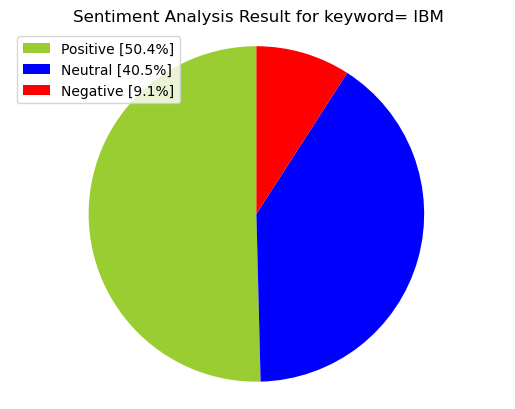

In [20]:

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword= "+keyword )
plt.axis('equal')
plt.savefig('pie.jpg')
plt.show()


In [13]:
tweet_list=pd.read_csv('./tweeet-list.csv')
tweet_list.drop_duplicates(inplace = True)
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
tw_list = pd.DataFrame()
tw_list["text"] = tweet_list['0'].drop_duplicates()
#Removing RT, Punctuation etc
# remove_rt = lambda x: re.sub('RT @\w+: ',"",x)
# rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([-9A-Za-z \t])|(\w+:\/\/\S+)","",x)
# tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
# tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)
                           

,text
0,@jimada_ibm @ms_hauwah @iamrauzzy @Jimada_Gana...
1,RT @RoadtoBitcoin: @LivepeerOrg impact - eye ...
2,"@IBMorg @IBM Hi, we're developing the ECAP res..."
3,Happy to be an IBM Platinum Business Partner: ...
4,RT @William28855416: @alexa99\nCivilian aircra...
5,//Take IBM for example. It is not only gearing...
7,IBM partners with The Recording Academy for Gr...
10,RT @Testbookdotcom: Which company has signed a...
11,Updated versions of IBM tools to speed mainfra...
12,RT @SCM_Ronald: “If ever there was a time to r...


In [16]:

clean_tweets = []
for tweet in tw_list['text']:
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
            if w.lower() in words or not w.isalpha())
    
    clean_tweets.append(tweet)
tw_list['tweet'] = clean_tweets
tw_list.head()

,text,tweet
0,@jimada_ibm @ms_hauwah @iamrauzzy @Jimada_Gana...,
1,RT @RoadtoBitcoin: @LivepeerOrg impact - eye ...,: impact - eye opening $ 188 / month $ 75 / mo...
2,"@IBMorg @IBM Hi, we're developing the ECAP res...","Hi , we ' re the research combining WHO , and ..."
3,Happy to be an IBM Platinum Business Partner: ...,Happy to be an Platinum Business Partner :
4,RT @William28855416: @alexa99\nCivilian aircra...,": Civilian aircraft , , have = = on board , so..."


In [11]:
score

{'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'compound': 0.7783}

In [17]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['tweet'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = 'negative'
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = 'positive'
    else:
        tw_list.loc[index, 'sentiment'] = 'neutral'
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp
tw_list.head(10)

,text,tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,@jimada_ibm @ms_hauwah @iamrauzzy @Jimada_Gana...,,0.000000,0.000000,neutral,0.000,0.000,0.000,0.0000
1,RT @RoadtoBitcoin: @LivepeerOrg impact - eye ...,: impact - eye opening $ 188 / month $ 75 / mo...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
2,"@IBMorg @IBM Hi, we're developing the ECAP res...","Hi , we ' re the research combining WHO , and ...",-0.125000,0.375000,neutral,0.000,1.000,0.000,0.0000
3,Happy to be an IBM Platinum Business Partner: ...,Happy to be an Platinum Business Partner :,0.800000,1.000000,positive,0.000,0.619,0.381,0.5719
4,RT @William28855416: @alexa99\nCivilian aircra...,": Civilian aircraft , , have = = on board , so...",0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
5,//Take IBM for example. It is not only gearing...,// Take for example . It is not only gearing t...,0.000000,0.500000,negative,0.099,0.901,0.000,-0.2960
7,IBM partners with The Recording Academy for Gr...,with The Recording Academy for With,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
10,RT @Testbookdotcom: Which company has signed a...,: Which company an MoU with Government ' s to ...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
11,Updated versions of IBM tools to speed mainfra...,of to speed application modernization . Read m...,0.500000,0.500000,neutral,0.000,1.000,0.000,0.0000
12,RT @SCM_Ronald: “If ever there was a time to r...,: “ If ever there was a time to rally around o...,0.068182,0.477273,neutral,0.000,1.000,0.000,0.0000


In [11]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [21]:
tw_list_negative.head(50)

,Unnamed: 0,text,tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,5,//Take IBM for example. It is not only gearing...,// Take for example . It is not only gearing t...,0.000000,0.500000,negative,0.099,0.901,0.000,-0.2960
1,36,"RT @bizdevgcc: IBM: The Good, The Bad And The ...",": : The Good , The Bad And The Ugly ( : )",-0.050000,0.816667,negative,0.496,0.292,0.212,-0.5994
2,54,@datajake1999 Hey just heard about your SAPI5 ...,Hey just about your SAPI5 . When I git clone i...,0.000000,0.000000,negative,0.145,0.855,0.000,-0.2960
3,55,Nobody gets fired for buying IBM... https://t....,Nobody fired for ...,0.000000,0.000000,negative,0.545,0.455,0.000,-0.5574
4,65,@VMwareTanzu @VMware without require kubernete...,"without require , make easy to duplicate , dep...",0.433333,0.833333,negative,0.231,0.769,0.000,-0.3412
5,84,RT @RutgersU: When he's not on the court for @...,": When he ' s not on the court for , doing his...",0.000000,0.000000,negative,0.123,0.877,0.000,-0.2732
6,100,RT @rwlord: Miss our 2020 annual report? Catch...,: Miss our 2020 annual report ? Catch up with ...,0.357143,0.535714,negative,0.159,0.841,0.000,-0.2244
7,104,@WholeMarsBlog They needa avoid becoming the I...,They avoid becoming the of the industry .... w...,0.450000,0.850000,negative,0.167,0.833,0.000,-0.2960
8,105,RT @wtejada223: What a disruptive year we had....,: What a disruptive year we had . Take a look ...,0.000000,0.000000,negative,0.095,0.905,0.000,-0.3182
9,114,RT @thomask_cole: Again almost 6000 documents ...,cole : Again almost 6000 by . $ data by agains...,0.000000,0.000000,negative,0.297,0.703,0.000,-0.5859


In [18]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
neutral,8152,47.94
positive,7314,43.01
negative,1540,9.06


In [19]:
pc=count_values_in_column(tw_list,'sentiment')

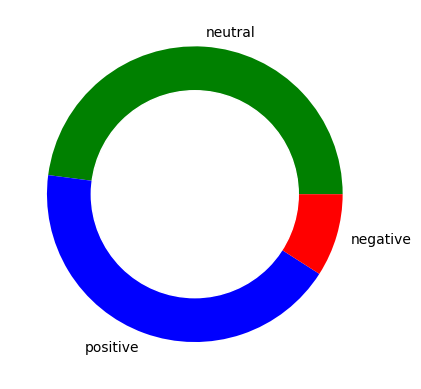

In [14]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig('pie2.jpg',bbox_inches='tight')
plt.show()

In [20]:
#Function to Create Wordcloud
def create_wordcloud(text,name):
#     mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                   max_words=3000,stopwords=stopwords,repeat=True)
    wc.generate(str(text))
    wc.to_file(name+".png")
    print("Word Cloud Saved Successfully")
    path=name+".png"
    display(Image.open(path))

Word Cloud Saved Successfully


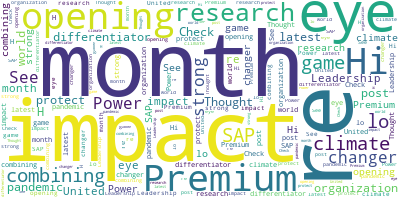

In [21]:
#Creating wordcloud for all tweets
create_wordcloud(tw_list["tweet"].values,'twc')


Word Cloud Saved Successfully


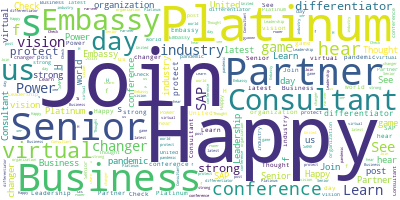

In [10]:
create_wordcloud(tw_list_positive["tweet"].values,'twp')

Word Cloud Saved Successfully


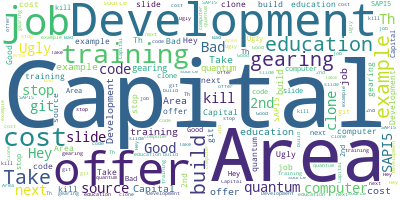

In [9]:
create_wordcloud(tw_list_negative["tweet"].values,'twne')

Word Cloud Saved Successfully


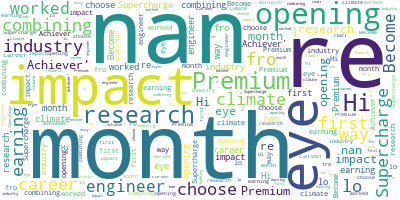

In [12]:
create_wordcloud(tw_list_neutral["tweet"].values,'twn')

In [20]:
#Calculating tweet’s lenght and word count
tw_list['text_len'] = tw_list['tweet'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['tweet'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,74.35
neutral,57.25
positive,73.30


In [21]:
# Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text
tw_list['punct'] = tw_list['tweet'].apply(lambda x: remove_punct(x))
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))
#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
tw_list.head()

,text,tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,@jimada_ibm @ms_hauwah @iamrauzzy @Jimada_Gana...,,0.000,0.000,neutral,0.0,0.000,0.000,0.0000,0,0,,[],[],[]
1,RT @RoadtoBitcoin: @LivepeerOrg impact - eye ...,: impact - eye opening $ 188 / month $ 75 / mo...,0.000,0.000,neutral,0.0,1.000,0.000,0.0000,80,22,impact eye opening 188 month 75 month Pr...,"[, impact, eye, opening, 188, month, 75, month...","[, impact, eye, opening, 188, month, 75, month...","[, impact, eye, open, 188, month, 75, month, p..."
2,"@IBMorg @IBM Hi, we're developing the ECAP res...","Hi , we ' re the research combining WHO , and ...",-0.125,0.375,neutral,0.0,1.000,0.000,0.0000,74,19,Hi we re the research combining WHO and oth...,"[hi, we, re, the, research, combining, who, an...","[hi, research, combining, climate, lo, ]","[hi, research, combin, climat, lo, ]"
3,Happy to be an IBM Platinum Business Partner: ...,Happy to be an Platinum Business Partner :,0.800,1.000,positive,0.0,0.619,0.381,0.5719,42,8,Happy to be an Platinum Business Partner,"[happy, to, be, an, platinum, business, partne...","[happy, platinum, business, partner, ]","[happi, platinum, busi, partner, ]"
4,RT @William28855416: @alexa99\nCivilian aircra...,": Civilian aircraft , , have = = on board , so...",0.000,0.000,neutral,0.0,1.000,0.000,0.0000,73,19,Civilian aircraft have on board some por...,"[, civilian, aircraft, have, on, board, some, ...","[, civilian, aircraft, board, portable, us, co...","[, civilian, aircraft, board, portabl, us, cor..."


In [22]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['tweet'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

17006 Number of reviews has 5584 words


,,aa,aal,abandon,abb,abctrust,abil,abl,abli,aboard,...,zenith,zephyr,zero,ziggurat,zip,zone,zoo,zoom,zs,𝒟𝒾𝑒𝒷𝒪
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
cloud,1532
ai,1532
new,1059
data,1048
market,954
us,652
work,626
learn,614
use,591
busi,585


In [24]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#n2_bigram
n2_bigrams = get_top_n_gram(tw_list['tweet'],(2,2),20)
n2_bigrams

[('hybrid cloud', 417),
 ('civilian aircraft', 234),
 ('artificial intelligence', 234),
 ('aircraft mil', 233),
 ('mil board', 232),
 ('board portable', 231),
 ('vaccine campaign', 214),
 ('campaign climbing', 212),
 ('climbing daily', 205),
 ('daily brief', 205),
 ('cloud satellite', 175),
 ('magic quadrant', 175),
 ('digital health', 153),
 ('cisco cisco', 140),
 ('cloud data', 139),
 ('covid 19', 138),
 ('portable na', 135),
 ('used equipment', 134),
 ('equipment cisco', 134),
 ('supply chain', 121)]

In [25]:
n3_trigrams = get_top_n_gram(tw_list['tweet'],(3,3),20)
n3_trigrams


[('civilian aircraft mil', 233),
 ('aircraft mil board', 232),
 ('mil board portable', 230),
 ('vaccine campaign climbing', 212),
 ('campaign climbing daily', 205),
 ('climbing daily brief', 205),
 ('board portable na', 135),
 ('used equipment cisco', 134),
 ('equipment cisco cisco', 134),
 ('digital health pass', 93),
 ('2021 magic quadrant', 81),
 ('leader 2021 magic', 72),
 ('hybrid cloud strategy', 59),
 ('data science machine', 59),
 ('develop potential break', 56),
 ('magic quadrant data', 53),
 ('covid 19 vaccine', 52),
 ('cloud application modernization', 52),
 ('new designed accelerate', 52),
 ('hybrid cloud application', 52)]